# Homework 4: Random Forests

*In this homework, you will work with a Speed Dating Dataset and apply the Random Forest model on the dataset after establishing preprocessing tasks.*

**Submission Instructions**

---
It is important that you follow the submission instructions. 
1. Copy this assignment notebook to your Drive. <font color = 'red'> `File` --> `Save a copy in Drive`</font>. Rename it as <font color = 'green'>`Lastname_Firstname_hw4`</font>.

2. Write your solutions in the cells  marked <font color = 'green'>`# your code`</font>.

3. **Do not delete your outputs. They are essential for the grading. Make sure that cells containing your solutions are executed, and the results are displayed on the notebook.**

4. When you're done please submit your solutions as an <font color="red">`.ipynb`</font> file. To do so:

  - Click on <font color="red">`File`</font>  at the top left on the Colab screen, then click on <font color = 'red'>`Download .ipynb`</font>.
  - Then submit the downloaded <font color="red">`.ipynb`</font> version of your work on SUCourse.


For any question, you may send an email to your TAs and LAs.

__________________________________
## Dataset Description

![](https://www.xfactordates.com/wp-content/uploads/2019/06/speeddating-1205-RGB-1-780x415.jpg)

In this homework, you will work on a simplified version of the [Speed Dating Experiment dataset from Kaggle](https://www.kaggle.com/annavictoria/speed-dating-experiment). 

Each instance in the dataset denotes a speed date between a participant and an assigned partner. For clarity, the descriptions below call the first participant as the main participant and the second participant as the assigned participant. 

The first 8 attributes in the dataset give information about the participants and their speed date assignment in the whole event. Among these attributes, ones that are not self-explanatory are described below.

```
iid: Unique participant number,
pid: Unique assigned partner number
wave: Number of the session where date took place
round: Number of people that met in wave
position: Station number where met partner (You can consider this like table number)
order: The number of date that night when met partner
```

After these features, we have the attributes regarding the preferences and scores of both the participant and the other assigned participant. Here, the easiest way to understand whether an attribute is for the main participant or the assigned participant is from the names of these attributes. Attributes including the `_o` in them belong to the assigned participants. To explain this further, below are attributes showing the scores given to the assigned participant by the main participant.

```
These are score attributes given to assigned partner (from 1 to 10)
attr: Rating of attractiveness
sinc: Rating of sincerity
intel: Rating of intelligence
fun: Rating of how fun the person is
amb: Rating of ambitiousness
shar: Rating of shared interests
like: Rating of liking the person
prob: Rating of probability of further dates with the person
```

As explained above, this time, the following attributes are scores given to the main participant by the assigned participant: `attr_o, sinc_o, intel_o, fun_o, amb_o, shar_o, like_o, prob_o`.

In addition to these features, you will also see numbered features like `attr2_1` or `sinc3_1`. For these features, the first number denotes the context of these attributes. Below, you can see the questions asked to participants for these attributes.

```
Question 1: Please rate the importance of the following attributes in a potential date.
(Total 100 points are distributed among features below.)
  - attr1_1, sinc1_1, intel1_1, fun1_1, amb1_1, shar1_1 are responses of participants to the Question 1

Question 2: What do you think the opposite sex looks for in a date?
(Total 100 points are distributed among features below.)
  - attr2_1, sinc2_1, intel2_1, fun2_1, amb2_1, shar2_1 are responses of participants to the Question 2

Question 3: How do you think you measure up?
(From 1 to 10 for each feature)
  - attr3_1, sinc3_1, intel3_1, fun3_1, amb3_1, shar3_1 are responses of participants to the Question 3
```

The second number denotes the time of feature being recorded. As these features are recorded multiple times during and after the event, 
in the original dataset there are features with different record times. In our simplified version, we only selected the initial answers of these individuals, so that the second number in these features are always 1.  

Additionally, there are features coded as `pf_o_attr, pf_o_sin, pf_o_int, pf_o_fun, pf_o_amb, pf_o_sha`. These features denote the initial preferences of the assigned participant in a potential date *(Total 100 points are distributed among features)*.

Most of the features in the dataset consist of numeric ordinal values. After establishing the tasks introduced in the Data Preprocessing, the dataset is almost ready to be applied to machine learning models.

In the machine learning part, we will be interested in predicting the decision of the participants' to continue dating the assigned partner. Values for information are stored in the `dec` attribute. Similar to the attributes described earlier, we also have assigned partners' decisions stored in the `dec_o` attribute.

For other features and further information about the attributes, you can visit the Kaggle page for the dataset and check the Data Key file shared there. However, please note that the dataset used in this homework is a simplified format of the original dataset to make your processes easier. Because of this, some of the attributes documented in the Data Key file may not be in the dataset shared with you.

________________________________

In [27]:
from google.colab import drive
drive.mount("./drive", force_remount= True)

path_prefix = "./drive/My Drive"

Mounted at ./drive


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

%matplotlib inline

In [29]:
fname = "SpeedDatingData.csv"
df = pd.read_csv(join(path_prefix, fname))
df.head()

,iid,id,gender,wave,round,position,order,pid,samerace,age_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,undergra,mn_sat,tuition,imprace,imprelig,from,zipcode,income,goal,date,go_out,sports,tvsports,...,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es
0,1,1.0,0,1,10,7,4,11.0,0,27.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,NaN,NaN,NaN,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,9.0,2.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0,4.0
1,1,1.0,0,1,10,7,3,12.0,0,22.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,NaN,NaN,NaN,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,9.0,2.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0,4.0
2,1,1.0,0,1,10,7,10,13.0,1,22.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,NaN,NaN,NaN,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,9.0,2.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0,4.0
3,1,1.0,0,1,10,7,5,14.0,0,23.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0,21.0,NaN,NaN,NaN,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,9.0,2.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0,2.0,4.0
4,1,1.0,0,1,10,7,7,15.0,0,24.0,30.0,10.0,20.0,10.0,10.0,20.0,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0,2.0,21.0,NaN,NaN,NaN,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,9.0,2.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0,4.0


## Data Preprocessing

### Discarding Missing Values

#### Task 1: Missing Attribute Values

As the dataset in this homework is mostly built with survey answers, some of the attributes contain missing values. Although we can deal with these attributes without discarding them, it may be more beneficial to drop the ones having a lot of `NaN` values in them.

Your first task here is to display the attributes in which more than half of the instances are missing (i.e. `NaN`). Then drop these attributes from the dataframe.

In [30]:
#check each column's nan value and if it is greater than 4189, drop that column
for col in df.columns:
  if (df[col].isnull().sum() > len(df)/2):
    print("Column {} has more than half of the instances(4189) are NaN".format(col))
    df = df.drop([col], axis=1)

Column mn_sat has more than half of the instances(4189) are NaN
Column tuition has more than half of the instances(4189) are NaN
Column expnum has more than half of the instances(4189) are NaN


#### Task 2: Rows with Missing Values

Some of the rows in the dataset also contain a lot of missing attribute values. In such occurrences, it probably means that the details about the particular speed date were not recorded properly. Because of this, we should discard rows where the majority of the values are missing.

Your task is to discard rows in which the number of missing attribute values (`NaN` values) is more than half of the number of total attributes.

*hint: You can also check the number of missing values in a row by using `df.isnull().sum()` by passing the correct `axis` parameter value to the sum function.*

In [31]:
#create a temp array to store rows with greater NaN value count than threshold
majornan_rows= (df.isnull().sum(axis = 1) > df.shape[1]/2)
#drop all of the "true" (which means majority is NaN rather than non-NaN) rows
for i in range(len(majornan_rows)):
  if majornan_rows[i] == True:
    df = df.drop([i])

### Fixing Attributes

#### Task 3: Fixing `date` and `go_out`

If you check the `Speed Dating Data Key` file, you can see that entries in the `date` and `go_out` attributes are encoded as below.

```
date:
In general, how frequently do you go on dates? 
	Several times a week=1
	Twice a week=2
	Once a week=3
	Twice a month=4
	Once a month=5
	Several times a year=6
	Almost never=7

go_out:
How often do you go out (not necessarily on dates)?
	Several times a week=1
	Twice a week=2
	Once a week=3
	Twice a month=4
	Once a month=5
	Several times a year=6
	Almost never=7

```

Here, the maximum value 7 is used for describing answers with minimum values to these questions. Keeping these attributes as they are disrupting the ordinality built in these attributes. To obtain correct ordinality for `date` and `go_out` the minimum value for these attributes should be for `Almost never`.

To fix this, your task is to convert the value `7` in these attributes to value `0`.

In [32]:
#use replace method to fix ambiguity problem
df['date'] = df['date'].replace(7,0)
df['go_out'] = df['go_out'].replace(7,0)

#### Task 4: Fixing `goal`

When you check the `Speed Dating Data Key` file, you can see that entries in the `goal` attributes are encoded as below.

```
goal:
What is your primary goal in participating in this event? 
	Seemed like a fun night out=1
	To meet new people=2
	To get a date=3
	Looking for a serious relationship=4
	To say I did it=5
	Other=6
```

Unlike the earlier two attributes, `date` and `go_out`, `goal` attribute does not look like it is an ordinal feature. Because of this, leaving values as is, ordered from 1 to 6, implies that there is a hierarchy between the values.

To fix this, use one-hot-encoding to create one-hot features from the `goal` attribute. However, as `goal` attribute includes `NaN` values currently, we cannot directly use One-Hot-Encoding. We need to deal with the missing values first.

Your Task:
  - Fill the missing values with value `6` *(denotes to `other`)*
  - Create one-hot features from `goal` attribute,
  - Name these features `goal_fun, goal_meet, goal_date, goal_serious, goal_did, goal_other` respectively,
  - Add these features to the dataframe,
  - Lastly, discard the initial `goal` attribute.

In [33]:
from sklearn.preprocessing import OneHotEncoder
df["goal"] = df["goal"].fillna(6)

y = OneHotEncoder().fit_transform(df.goal.values.reshape(-1,1)).toarray()
new_features = ['goal_fun', 'goal_meet', 'goal_date', 'goal_serious', 'goal_did', 'goal_other']
for i in range(6):
  df[new_features[i]] = y[:,i]

df = df.drop(['goal'], axis=1)

#### Task 5: Rest of the `NaN` Values

As most of the features in the dataset consist of numeric ordinal values, one solution for `NaN` values can be filling with the median values.

- Check if there are `object` typed attributes in the dataset.
- If possible, convert them to `float` type.
- Then, discard columns with string values.
- Lastly, fill the remaining missing values in the dataset with corresponding column median values.

*hint: To get attributes with string values, you can check attributes which do not have the data type of `float64`.*

*hint 2: You may not be able to convert `income` values to float directly. To be able do that, you can omit the `,` in the initial income values.*


In [34]:
df = df.replace(',','', regex=True)
for col in df.columns:
  df[col] = df[col].apply(pd.to_numeric,errors='ignore')  #if possible convert them to float64

for col in df.columns:
  if (df[col].dtype == 'object'):   #if there is still unconverted columns
    df = df.drop([col], axis=1)    #drop those columns
  else:
    df[col] = df[col].fillna(df[col].median())    #fill the NaN values with median

## Applying Random Forest

#### Task 1: Dropping Unnecessary Attributes

Before moving on to applying machine learning, we need to discard features which do not yield any information about the problem we want to analyze with machine learning. As we want to predict the decision of the participant on dating, the attributes below are redundant.

Discard the redundant attributes listed below from the dataframe.

```
iid, id, wave, round, position, order
```

In [35]:
#dropping the columns redundant
df = df.drop(['iid', 'id', 'wave', 'round', 'position', 'order'], axis=1)

#### Task 2: Initial Random Forest Model

With the instructions below, build the initial Random Forest model.

1. Split the dataset into 80% training, 10% validation and 10% test set with `random_state` parameter set to a value different than 0.
2. Build a Random Forest model with `criterion` set to `entropy`.
3. Train the model on the training set.
4. Report the accuracy on the validation set.

*Necessary import statements are given for you in the cell below.*

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [37]:
#split the data that:
X = df.drop("dec",axis=1)   #features to be used in prediction
y = df["dec"] #feature to be predicted

In [41]:
# %80 to %20 split
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.2,random_state=40)
# %10 and %10 split
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5,random_state=40)

#Random forest application
model_rf = RandomForestClassifier(random_state=40, criterion='entropy')
model_rf.fit(X_train, y_train,)

#prediction accuracy rate
rf_predictions = model_rf.predict(X_valid)
rf_acc = accuracy_score(y_valid, rf_predictions)

print("Random Forest Accuracy:"+str(rf_acc))

Random Forest Accuracy:0.8361445783132531


#### Task 3: Feature Importances

Importance of features from a Random Forest model can be checked after the training is complete. To do that, you can use the `feature_importances_` attribute of a Random Forest model instance.

To analyze importances of different features in our dataset, plot the most important 25 features of the model you trained above in a horizontal bar chart. You can use the plot below for referencing.

![](https://linkpicture.com/q/features.png)

To achieve the colors of the plot, it was built with a certain colormap existing in matplotlib library. To obtain a colormap from matplotlib, you can use `cm.NameOfTheColorMap` and create a colormap instance. You can also pass a `np.linspace` as a parameter to a colormap, with the number of data instances you want to plot. This way, you can create a certain amount of colors to pass as a `color` parameter to the bar chart.

*You can check available colormaps from the matplotlib [documentation link](https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html).* 

*Necessary import statement is given for you in the cell below.*

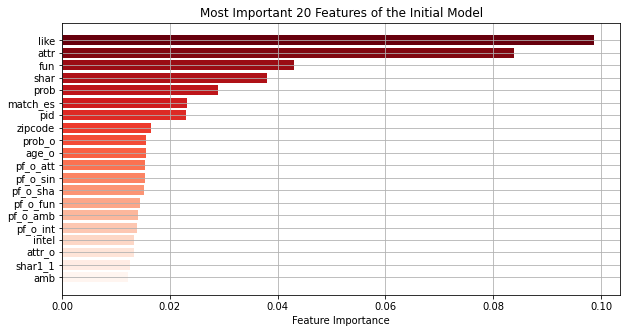

In [42]:
from matplotlib import cm
import matplotlib.colors as colors

#match importance score with column names
dict_importances = {}
importances = model_rf.feature_importances_
for i in range(len(importances)):
  dict_importances[X.columns[i]] = importances[i]

#sort the dictionary according to scores
dict_importances = sorted(dict_importances.items(), key=lambda x: x[1])
labels = [i for i,j in dict_importances]
importances = [j for i,j in dict_importances]

my_cmap = plt.get_cmap("Reds")

#plot the first 20 indices of dict's keys and values, with cmp 'Reds'
fig, ax = plt.subplots(figsize=(10,5))
ax.barh(labels[-20:], importances[-20:], color=my_cmap(np.linspace(0,1,len(importances[-20:]))))
ax.grid(True)
ax.set_title("Most Important 20 Features of the Initial Model")
ax.set_xlabel("Feature Importance")
plt.show()

## Grid Search

Grid search is one of the existing approaches to hyperparameter tuning for machine learning models. With Grid Search, we methodically build and evaluate a model for each combination of parameter space specified in a grid. This allows us to obtain the best performing hyperparameter options for the model we want to use.

sklearn library does have an implementation of Grid Search method available for all of its model. You can check the Grid Search from the sklearn [documentation link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

### Task 1: Selecting Optimum Parameters

Apply Grid Search for the initial Random Forest model with the given parameter space below.

```
n_estimators: 100, 200, 300
min_samples_split: 2, 4
```

- Train Random Forest instances with the given parameter space using GridSearchCV,
- Show the hyperparameters best performing model on the training set using `best_params_` attribute,
- Predict validation instances with best performing hyperparameters,
- Compare the accuracy score you obtained here with the accuracy score of the initial model.
- Use the markdown cell for your comments.

*hint: If you use `grid_search_object.predict()` it uses the model instance which performs best on the training set.*

*Necessary import statement is given for you in the cell below.*

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
#parameters to be compared
param_grid = {"n_estimators":[100, 200, 300], "min_samples_split":[2, 4]}

rf_grid = GridSearchCV(estimator = model_rf, param_grid = param_grid)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,

With given parameters, accuracy score was: 0.8361445783132531.

It increases to 0.8493975903614458 with using gridsearch cross validation.

The increase is slight, so the parameters that given at first place was already good enough.

In [45]:
# Displaying best hyperparameters
rf_grid.best_params_

{'min_samples_split': 2, 'n_estimators': 300}

In [46]:
# Accuracy score with new hyperparameters
grid_preds = rf_grid.predict(X_valid)
accuracy_score(y_valid, grid_preds)

0.8493975903614458

### Task 2: Confusion Matrix

By using the best performing hyper-parameters from the earlier task, Check the accuracy score of the model on the test set. Lastly, evaluate the performance of the model on the test set by checking the confusion matrix. Use the cell given to you below for your evaluation.

*Necessary import statement is given for you in the cell below.*

In [47]:
from sklearn.metrics import confusion_matrix

In [53]:
mat = confusion_matrix(y_test, grid_preds)
print(mat)

[[308 205]
 [191 126]]


True predictions are: 308 (0/0) and 126 (1/1)

False ones are: 205 (Guessing 1, but actually 0) and 191 (Guessing 0 for 1) 

Therefore in total: (308+126)\(308+126+205+191) ~= 0.52

Success of 0's: 308/308+205 ~= 0.60

Success of 1's: 126/126+191 ~= 0.397

It can be concluded that predicting 0's are more accomplished than predicting 1's by this random forest model. Also, total ratio is close to %50 and there is only two option. Therefore, model should be developed further in order to obtain more accomplished prediction